WIP solution guide for w1d4 by Chris MacLeod

In [5]:
import einops
import matplotlib.pyplot as plt
import torch
import tqdm.notebook
from torchvision import models
from torchvision.utils import make_grid
from torchvision.transforms import ColorJitter, RandomAffine
import pandas as pd

plt.rcParams["figure.figsize"] = (12, 12)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)
model = models.resnet34(pretrained=True)
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)

def imshow(img, fig=None):
    if fig is None:
        fig, ax = plt.subplots()
    if len(img.shape) == 4:
        img = img.squeeze(0)
    # CM: are these labeled wrong? I thought height comes before width?
    img_reshaped = einops.rearrange(img, 'c h w -> h w c')
    # CM: why do we need detach here?
    ax.imshow(img_reshaped.detach())
    ax.set(xticks=[], yticks=[])


cpu


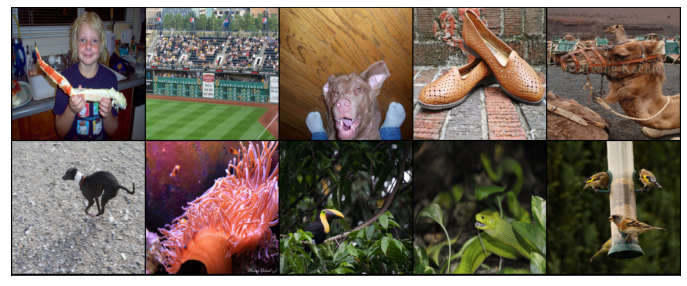

In [6]:
# TODO: don't have this on GPU in the first place
# Time permitting students could form the decorrelation matrix themselves
# instead of having magic numbers
examples = torch.load('imagenet-batch.pt', map_location=torch.device('cpu'))
# Exercise: which channels are red, green, and blue? Verify visually.
#examples[:, 0:2] = 0
imshow(make_grid(examples[:10], nrow=5))

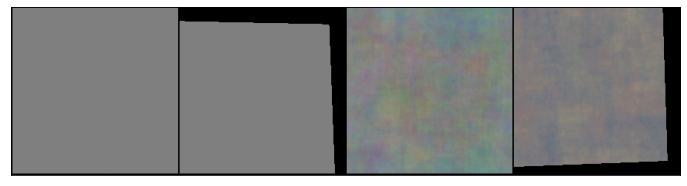

In [7]:
from torch import nn

class LearnableImage(nn.Module):
    IMAGE_SHAPE = (1, 3, 224, 224)

    # 50 is American Alligator: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
    def __init__(self, target_logit=50):
        super().__init__()
        self.params = None
        self.layers = None
        self.target_logit = target_logit

    def forward(self):
        return self.layers(self.params)

    def loss(self, logits):
        return -logits[self.target_logit]

    # CM: why is 0.01 good and not something else?
    def rand_image(self, standard_deviation=0.01):
        return standard_deviation * torch.randn(self.IMAGE_SHAPE)

# Q: what will the range be before the sigmoid? After the sigmoid?

class UniformInit(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(torch.rand(self.IMAGE_SHAPE))
        self.layers = nn.Sequential(nn.Sigmoid())


class NormalInit(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(self.rand_image())
        self.layers = nn.Sequential(nn.Sigmoid())


class DataAugmentation(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(self.rand_image())
        self.layers = nn.Sequential(
            ColorJitter(0.1, 0.1, 0.1, 0.1),
            nn.Sigmoid(),
            RandomAffine(10, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=5)
        )


class LinearDecorrelateColor(nn.Module):
    def __init__(self):
        super().__init__()
        color_correlation_svd_sqrt = torch.tensor(
            [[0.26, 0.09, 0.02],
            [0.27, 0.00, -0.05],
            [0.27, -0.09, 0.03]], dtype=torch.float32)
        max_norm_svd_sqrt = torch.max(torch.linalg.norm(color_correlation_svd_sqrt, axis=0))
        self.mat = color_correlation_svd_sqrt / max_norm_svd_sqrt

    def __call__(self, x):
        return torch.einsum('...khw,kc->...chw', x, self.mat)


class ColorDecorrelation(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(self.rand_image())
        self.layers = nn.Sequential(
            LinearDecorrelateColor(),
            ColorJitter(0.1, 0.1, 0.1, 0.1),
            nn.Sigmoid(),
            RandomAffine(10, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=5)
        )


def random_spectra(init_sd=0.1):
    return torch.view_as_complex(init_sd * torch.randn((1, 3, 224, 113, 2)))


class SpectraToImage(nn.Module):
    def __init__(self, scale=None):
        super().__init__()
        self.scale = scale

    def forward(self, spectra):
        if self.scale is not None:
            spectra = spectra * self.scale
        return torch.fft.irfft2(spectra, s=(224, 224)).float()


class FourierSpace(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(random_spectra())
        self.layers = nn.Sequential(
            SpectraToImage(),
            nn.Sigmoid(),
        )

class FourierSpaceScaled(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(random_spectra())
        self.layers = nn.Sequential(
            SpectraToImage(torch.load('result.pt')),
            nn.Sigmoid(),
        )


class Everything(LearnableImage):
    def __init__(self):
        super().__init__()
        self.params = nn.Parameter(random_spectra())
        self.layers = nn.Sequential(
            SpectraToImage(torch.load('result.pt')),
            LinearDecorrelateColor(),
            nn.Sigmoid(),
            ColorJitter(0.1, 0.1, 0.1, 0.1),
            RandomAffine(10, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=5)
        )

# Is it useful to scale here to 0-1?
def show_experiments():
    imshow(make_grid(torch.concat([e() for e in experiments]), nrow=2))

experiments = [
    #UniformInit(), 
    NormalInit(), 
    #DataAugmentation(),
    ColorDecorrelation(),
    #FourierSpace(), # had zero gradient - what's wrong here?
    FourierSpaceScaled(),
    Everything()
]
# for e in experiments:
#     e.target_logit = 971 # bubble
show_experiments()



In [8]:
n_iterations = 2048
model.requires_grad_(False)
optim = torch.optim.Adam([p for e in experiments for p in e.parameters()], lr=0.05)

all_images = torch.zeros((n_iterations, len(experiments), 3, 224, 224), dtype=torch.float32)
all_losses = torch.zeros((n_iterations, len(experiments)), dtype=torch.float32)
all_grad_norms = torch.zeros((n_iterations, len(experiments)), dtype=torch.float32)
for i in tqdm.notebook.trange(n_iterations):
    optim.zero_grad()
    batch = torch.concat([e() for e in experiments])
    all_images[i] = batch.detach()
    logits = model(batch) # (batch, output_classes)
    total_loss = 0
    for j, e in enumerate(experiments):
        loss = e.loss(logits[j])
        total_loss += loss
        all_losses[i, j] = float(loss) # detach
    total_loss.backward()
    for j, e in enumerate(experiments):
        # TODO: don't think this is right for complex params?
        all_grad_norms[i, j] = (e.params.grad.abs() ** 2).sum().sqrt()
    optim.step()

show_experiments()

  0%|          | 0/2048 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
from ipywidgets import widgets, interact
interact(lambda iteration_num: imshow(make_grid(all_images[iteration_num], nrow=2)), 
    iteration_num=widgets.IntSlider(
    value=0,
    min=0,
    max=n_iterations-1,
    step=1
));

interactive(children=(IntSlider(value=0, description='iteration_num', max=2047), Output()), _dom_classes=('wid…

<AxesSubplot:title={'center':'Activation vs Iterations'}, xlabel='Iteration', ylabel='Loss'>

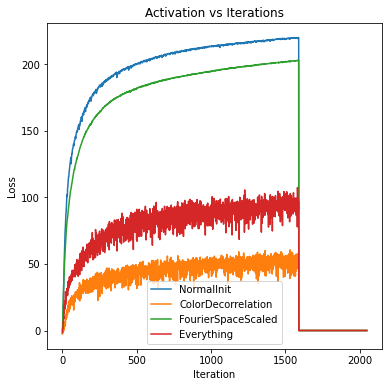

In [10]:
df = pd.DataFrame(-all_losses.numpy(), columns=[e.__class__.__name__ for e in experiments])
df.plot(title='Activation vs Iterations', figsize=(6,6), xlabel='Iteration', ylabel='Loss')

<AxesSubplot:title={'center':'Gradient Norm vs Iterations'}, xlabel='Iteration', ylabel='Gradient Norm'>

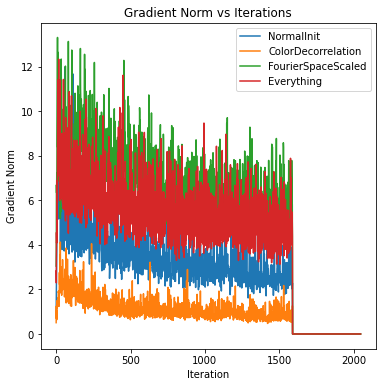

In [11]:
df = pd.DataFrame(all_grad_norms.numpy(), columns=[e.__class__.__name__ for e in experiments])
df.plot(title='Gradient Norm vs Iterations', figsize=(6,6), xlabel='Iteration', ylabel='Gradient Norm')

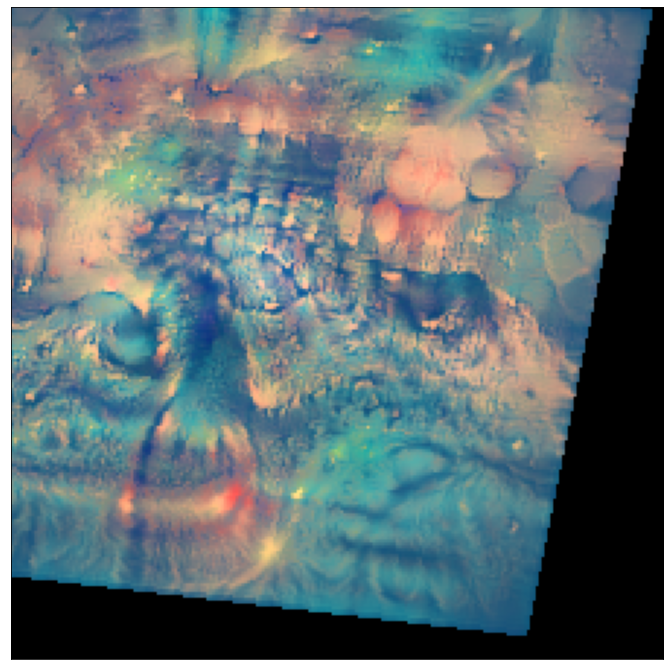

In [13]:
imshow(all_images[-1600,-1])